Main question: Home vs away's effect on performance. (Does having a race in your country affect performance?)

In [830]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [831]:
races            = pd.read_csv("./dataset/races.csv")
circuits         = pd.read_csv("./dataset/circuits.csv")
constructors     = pd.read_csv("./dataset/constructors.csv")
drivers          = pd.read_csv("./dataset/drivers.csv")
driver_standings = pd.read_csv("./dataset/driver_standings.csv")
demonyms         = pd.read_csv("./dataset/demonyms.csv")

In [832]:
import seaborn as sns
import matplotlib.pyplot as plt

def lookup_country(nationality: str) -> str:
    return demonyms[demonyms['nationality'] == nationality].iloc[0]['country']

def filter_home_or_away_results_only(df, grouping_column, filter_column):
    """Filter out drivers/constructors who have only one at home or not at home
    score remaining.  All drivers/constructors after this filteration should
    have a row at home and outside home"""
    counts = df.groupby([grouping_column])[filter_column].nunique()
    counts = counts[counts > 1]
    return df[df[grouping_column].isin(counts.index)]

def filter_outliers(data, column):
    # Calculate the first and third quartiles of the data
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Filter the data to keep only the rows where the data points fall within the range [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    return data[(data[column] >= q1 - 1.5*iqr) & (data[column] <= q3 + 1.5*iqr)]

def plot_home_vs_away(df, x, y, hue, title):
    # Set the style and context of the plot
    sns.set_style('whitegrid')
    sns.set_context('talk')

    # Create the grouped bar plot using seaborn
    sns.catplot(y=y, x=x, hue=hue, kind='bar', data=df, height=24, orient='h')

    # Set the plot title and axis labels
    plt.title(title)
    plt.ylabel(y)
    plt.xlabel(x)

    # Show the plot
    plt.show()

def plot_hist(df, data_column, grouping_column):
    away_data = df[df[grouping_column] == False][data_column]
    home_data = df[df[grouping_column] == True][data_column]

    plt.hist(away_data, histtype='step')
    plt.hist(home_data, histtype='step')

    plt.title(f'Histogram distribution of {data_column}')
    plt.legend(['Away', 'Home'])
    plt.ylabel(f'Frequency of {data_column}')
    plt.xlabel(data_column)
    plt.show()


##  Driver performance by points

In [833]:
# Alfonso Thiele had an American-Italian citizenship, but he mainly raced for an italian team
# The same applies for Alessandro de Tomaso.
alfonso_index = drivers[(drivers['forename'] == 'Alfonso') & (drivers['surname'] == 'Thiele')].index
alessandro_index = drivers[(drivers['forename'] == 'Alessandro') & (drivers['surname'] == 'de Tomaso')].index

drivers.loc[alfonso_index, 'nationality'] = 'Italian'
drivers.loc[alessandro_index, 'nationality'] = 'Italian'

# There are multiple east german drivers
drivers[drivers['nationality'] == 'East German'] = 'German'

In [834]:
# Convert nationalities to countries and make sure there are no nans.
display(drivers['nationality'])
drivers['country'] = drivers['nationality'].apply(lookup_country)
assert not drivers['country'].hasnans

0         British
1          German
2          German
3         Spanish
4         Finnish
          ...    
852        German
853       Chinese
854         Dutch
855    Australian
856      American
Name: nationality, Length: 857, dtype: object

In [835]:
races.rename(columns={'name':'race_name'}, inplace=True)
races = races[['raceId', 'circuitId', 'year', 'round']]

circuits.rename(columns={'name':'circuit_name'}, inplace=True)
circuits = circuits[['circuitId', 'country']]

races_circuits = pd.merge(races, circuits, on='circuitId', how='left')

display(races_circuits)

raceId  circuitId  year  round        country
0          1          1  2009      1      Australia
1          2          2  2009      2       Malaysia
2          3         17  2009      3          China
3          4          3  2009      4        Bahrain
4          5          4  2009      5          Spain
...      ...        ...   ...    ...            ...
1097    1116         69  2023     19            USA
1098    1117         32  2023     20         Mexico
1099    1118         18  2023     21         Brazil
1100    1119         80  2023     22  United States
1101    1120         24  2023     23            UAE

[1102 rows x 5 columns]

In [836]:
drivers = drivers[['driverId', 'country']]
drivers.rename(columns={'country': 'driver_country'}, inplace=True)

driver_standings = driver_standings[['raceId', 'driverId', 'points']]

circuits = circuits[['circuitId', 'country']]
circuits.rename(columns={'country': 'circuit_country'}, inplace=True)


# join the dataframes
driver_results = pd.merge(drivers, driver_standings, on='driverId')
driver_race_results = pd.merge(driver_results, races, on='raceId')
driver_circuit_results = pd.merge(driver_race_results, circuits, on='circuitId')
driver_circuit_results.drop(columns=['circuitId'], inplace=True)

display(driver_circuit_results)

df = driver_circuit_results

# Mark each race results as being in the driver's country or not.
df['driver_at_home'] = df['driver_country'] == df['circuit_country']
display(df['driver_at_home'].value_counts())

driverId  driver_country  raceId  points  year  round circuit_country
0            1  United Kingdom      18    10.0  2008      1       Australia
1            2         Germany      18     8.0  2008      1       Australia
2            3         Germany      18     6.0  2008      1       Australia
3            4           Spain      18     5.0  2008      1       Australia
4            5         Finland      18     4.0  2008      1       Australia
...        ...             ...     ...     ...   ...    ...             ...
33882      725  United Kingdom     825     0.0  1951      1     Switzerland
33883      741          France     825     0.0  1951      1     Switzerland
33884      763           Italy     825     3.0  1951      1     Switzerland
33885      764          France     825     0.0  1951      1     Switzerland
33886      765          France     825     0.0  1951      1     Switzerland

[33887 rows x 7 columns]

driver_at_home
False    32299
True      1588
Name: count, dtype: int64

In [837]:
# df = df[['driverId', 'raceId', 'year', 'points']]

# df.sort_values(['driverId','year'], ascending=[True,True], inplace=True)
# df['shift'] = df.groupby(['driverId','year'])['points'].shift()
# df['diff'] = df['points'] - df['shift']

df['points'] = df.sort_values(['raceId', 'round']).groupby(['year', 'driverId'])['points'].diff().fillna(0)

df.sort_values(['driverId', 'raceId'])

driverId  driver_country  raceId  points  year  round circuit_country   
446          1  United Kingdom       2     0.0  2009      2        Malaysia  \
14898        1  United Kingdom       3     3.0  2009      3           China   
849          1  United Kingdom       4     5.0  2009      4         Bahrain   
1272         1  United Kingdom       5     0.0  2009      5           Spain   
2208         1  United Kingdom       6     0.0  2009      6          Monaco   
...        ...             ...     ...     ...   ...    ...             ...   
15568      856     Netherlands    1095     0.0  2022     21          Brazil   
19794      856     Netherlands    1096     0.0  2022     22             UAE   
1167       856     Netherlands    1098     0.0  2023      1         Bahrain   
1168       857       Australia    1098     0.0  2023      1         Bahrain   
1169       858   United States    1098     0.0  2023      1         Bahrain   

       driver_at_home  
446             False  
14898           False  
849             False  
1272            False  
2208            False  
...               ...  
15568           False  
19794           False  
1167            False  
1168            False  
1169            False  

[33887 rows x 8 columns]

In [838]:
# Get driver ids for results at home and outside home.
home_drivers = set(df[df['driver_at_home'] == True]['driverId'])
away_drivers = set(df[df['driver_at_home'] != True]['driverId'])

# Find the intersection: the drivers who've had races in their home country, and in other countries.
international_drivers = home_drivers.intersection(away_drivers)
home_away_results = df[df['driverId'].isin(international_drivers)]

# Group by the driver id and whether they're at home or not, compute the mean
# for all races of the two groups for each driver, then filter such that we get drivers 
# with meaningful points. (There are a lot of them with just zeros)
home_away_results = home_away_results.groupby(['driverId', 'driver_at_home'])
point_means = home_away_results['points'].mean()
point_means = point_means[point_means > 0].to_frame().reset_index()

display(point_means)

point_means = filter_home_or_away_results_only(point_means, 'driverId', 'driver_at_home')

driverId  driver_at_home    points
0           2           False  1.261364
1           2            True  1.000000
2           3           False  7.417949
3           3            True  5.181818
4           4           False  4.979228
..        ...             ...       ...
249       842           False  2.198113
250       842            True  0.250000
251       845           False  0.050000
252       849           False  0.033333
253       852           False  0.454545

[254 rows x 3 columns]

count      mean       std       min       25%       50%   
driver_at_home                                                            
False            84.0  1.538409  1.888411  0.029703  0.449342  0.912852  \
True             84.0  2.008309  3.208458  0.100000  0.519737  1.000000   

                    75%        max  
driver_at_home                      
False           1.74566   9.722222  
True            2.00000  25.500000

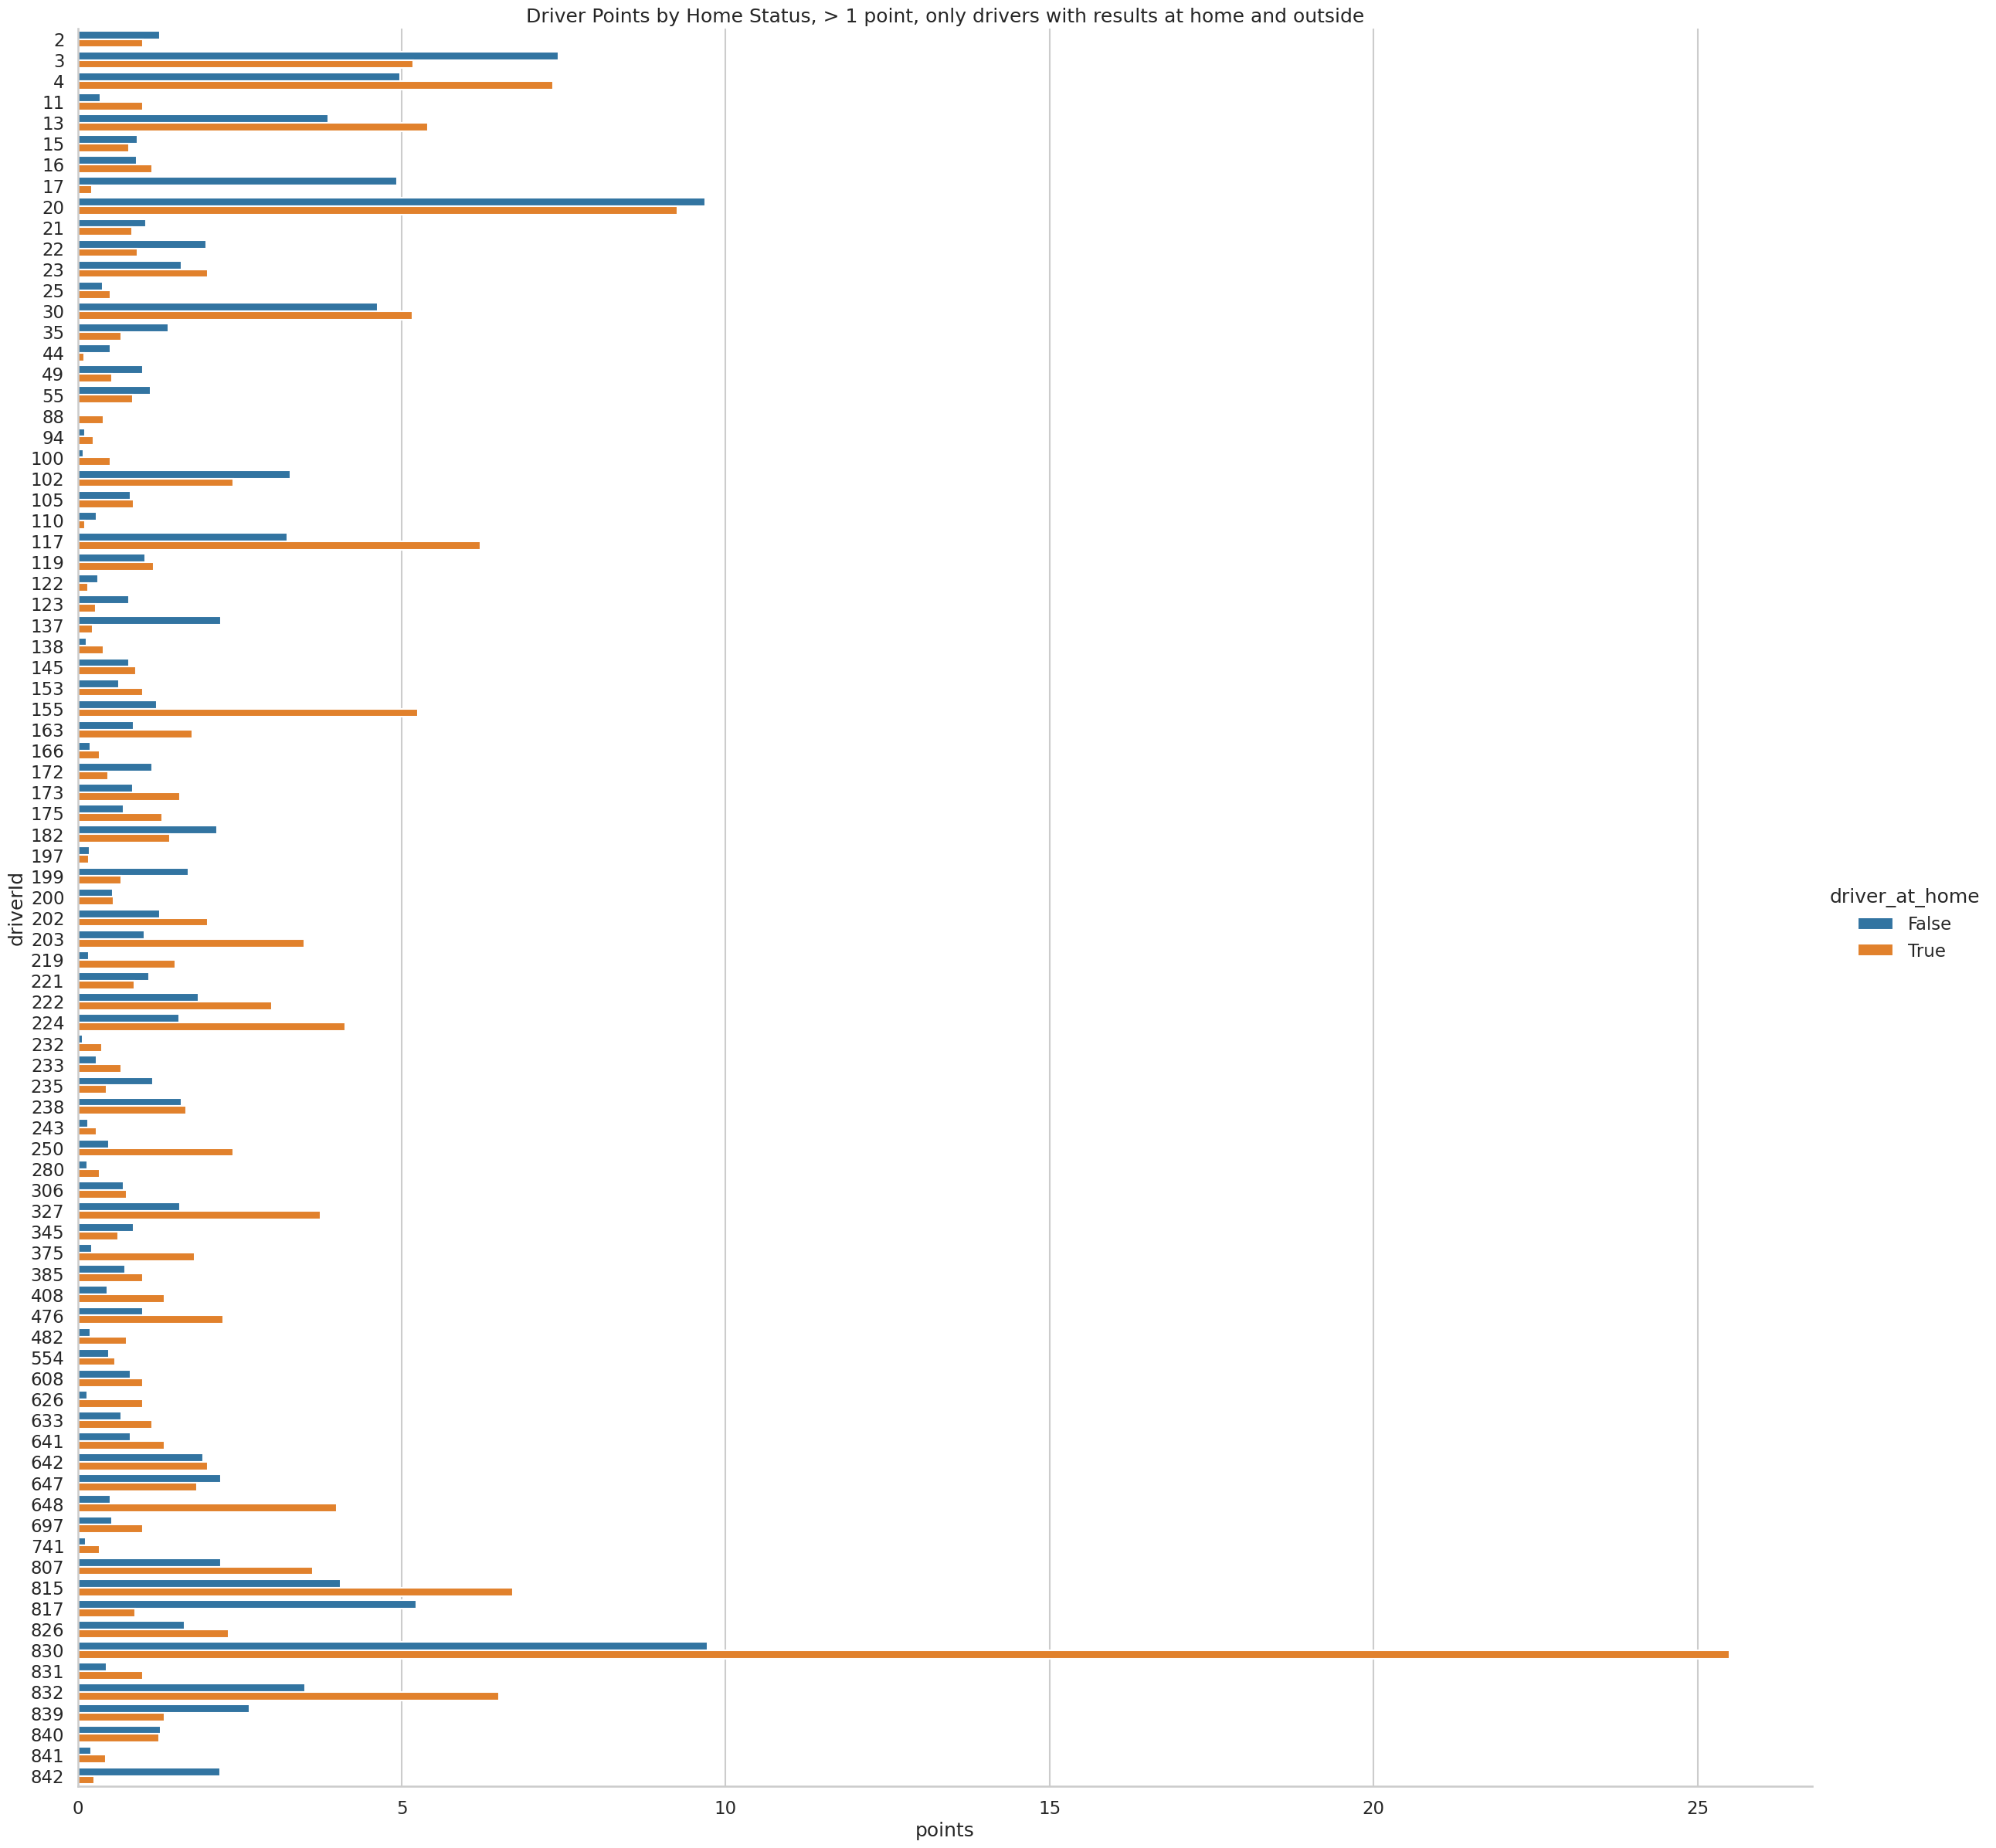

In [839]:
# Notice how there are quite a few outliers?
display(point_means.groupby('driver_at_home')['points'].describe())
plot_home_vs_away(point_means, 'points', 'driverId', 'driver_at_home', 'Driver Points by Home Status, > 1 point, only drivers with results at home and outside')

In [840]:
# The data shows great variation in the values we current have
# might be a good idea to filter it.
home = point_means['driver_at_home'] == True
away = point_means['driver_at_home'] != True

display(point_means.groupby('driver_at_home')['points'].describe())

point_means.loc[home] = filter_outliers(point_means[home], 'points')
point_means.loc[away] = filter_outliers(point_means[away], 'points')

point_means = filter_home_or_away_results_only(point_means, 'driverId', 'driver_at_home')

display(point_means.groupby('driver_at_home')['points'].describe())

count      mean       std       min       25%       50%   
driver_at_home                                                            
False            84.0  1.538409  1.888411  0.029703  0.449342  0.912852  \
True             84.0  2.008309  3.208458  0.100000  0.519737  1.000000   

                    75%        max  
driver_at_home                      
False           1.74566   9.722222  
True            2.00000  25.500000

count      mean       std       min       25%       50%   
driver_at_home                                                            
False            72.0  0.927457  0.714104  0.029703  0.334280  0.814474  \
True             72.0  1.181618  0.964450  0.100000  0.490385  0.961538   

                     75%       max  
driver_at_home                      
False           1.272321  3.284848  
True            1.517857  4.125000

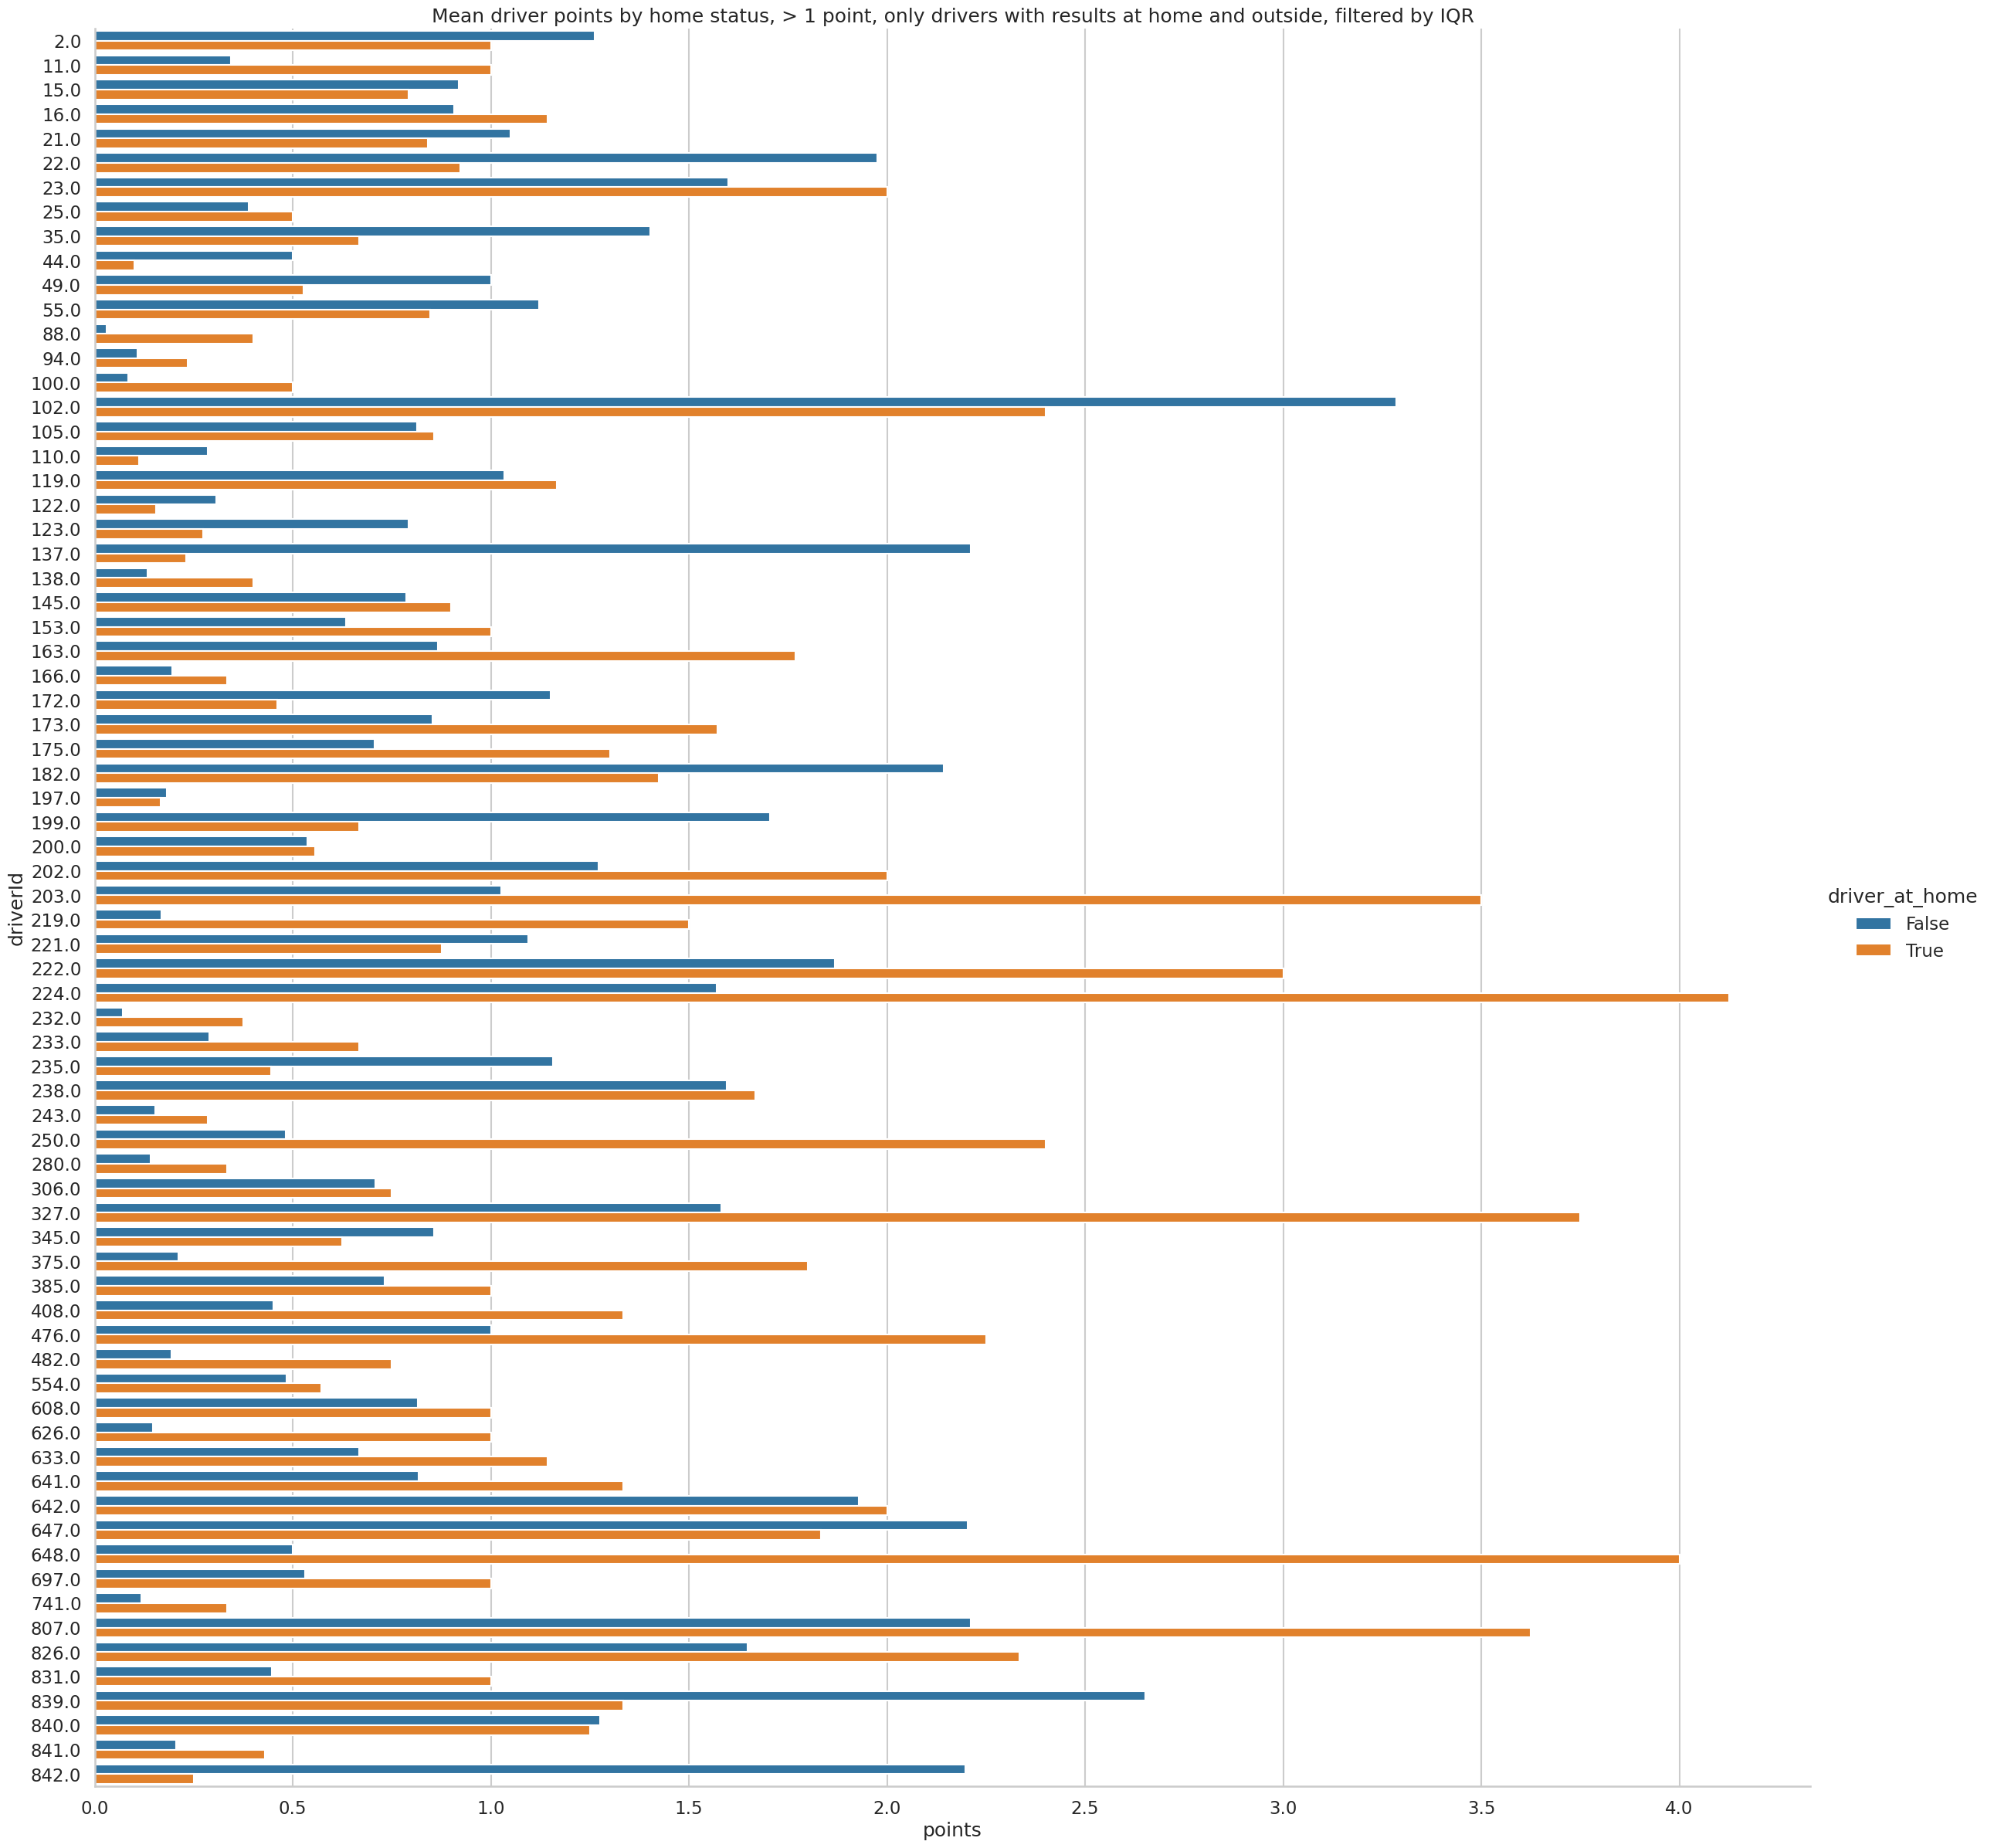

In [841]:
plot_home_vs_away(point_means, 'points', 'driverId', 'driver_at_home',  'Mean driver points by home status, > 1 point, only drivers with results at home and outside, filtered by IQR')